## RGB classification

`tf.keras.utils.image_dataset_from_directory`
Generates a `tf.data.Dataset` from image files in a directory.


Calling `image_dataset_from_directory`(main_directory, labels='inferred') will return a tf.data.Dataset that yields batches of images from the subdirectories class_a and class_b, together with labels 0 and 1 (0 corresponding to class_a and 1 corresponding to class_b).

#### Objective - To develop an image classifier using a `tf.keras.Sequential` model, using `tf.keras.utils.image_dataset_from_directory`. 

#### To do the following:
1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Identify overfitting and mitigate it through data augmentation and dropout.
6. Improve the model and repeat the process

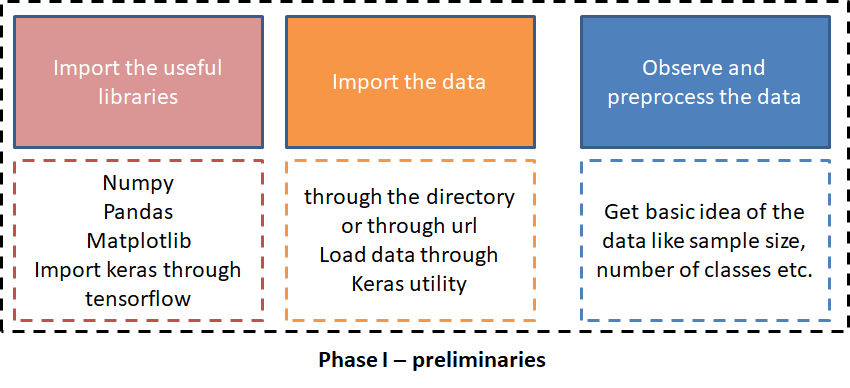

## Import TensorFlow and other useful libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL  
### Python Imaging Library (expansion of PIL) is the de facto image processing package for Python language.
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Download and explore the dataset

This tutorial uses a dataset of about 3,700 photos of flowers. 
The dataset contains five sub-directories, one per class:
images in data-set
1. daisy
2. dandelion
3. roses
4. sunflowers
5. tulips

#### Get the data-set through url

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

#### Know the total number of images in the data-set

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


#### Example of images:

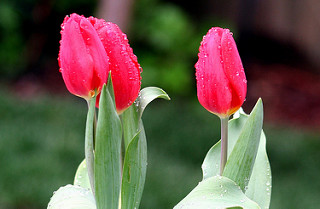

In [4]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

## Load data using a Keras utility

* Load these images off disk using `tf.keras.utils.image_dataset_from_directory` utility. 
    This will take us from a directory of images on disk to a `tf.data.Dataset`. 

## Create a dataset

Define useful parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

### Training, validating and knowing the class names

#### Splitting: 80% of the images for training, and 20% for validation.

#### training

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                      validation_split=0.2,
                                                      subset="training",
                                                      seed=123,
                                                      image_size=(img_height, img_width),
                                                      batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


#### validation

In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


#### know the class names: find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [8]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualizing the first nine images from the training dataset:

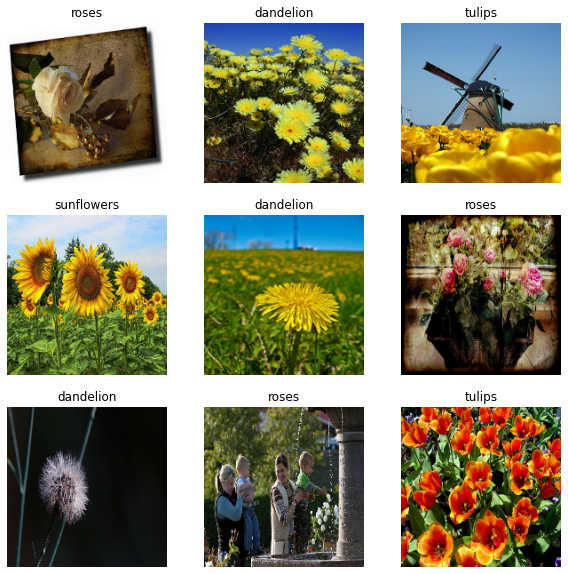

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8")) ##8-bit unsigned integer (0 to 255)#
        plt.title(class_names[labels[i]])
        plt.axis("off")

#### Manually iterating over the dataset and retrieving batches of images:

In [10]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


1. The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. 
2. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). 
3. The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.

## Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [12]:
normalization_layer = layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [13]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


Or, you can include the layer inside your model definition, which can simplify deployment. Let's use the second approach here.

Note: You previously resized images using the `image_size` argument of `tf.keras.utils.image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the `tf.keras.layers.Resizing` layer.

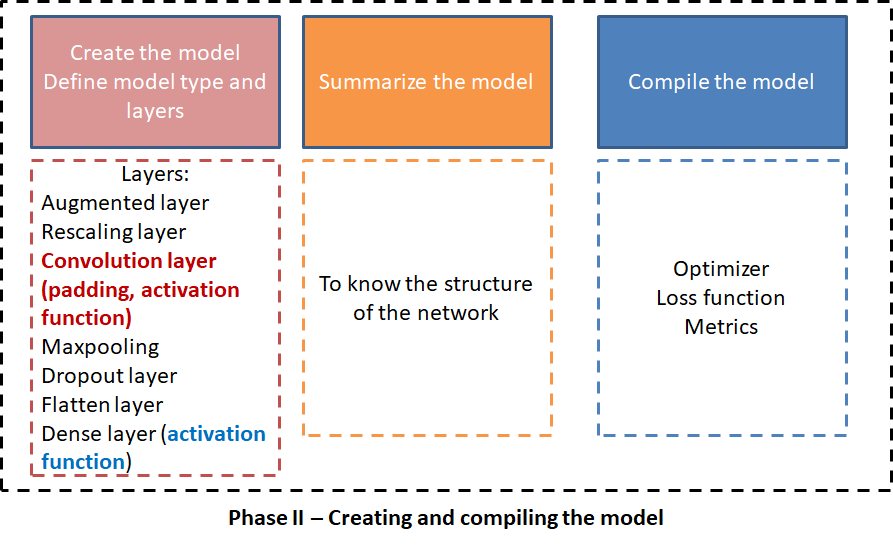

# Create the model

The Sequential model consists of three convolution blocks:
* (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. 
*  Fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). 


In [14]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Model summary

View all the layers of the network using the model's `Model.summary` method:

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

## Compile the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

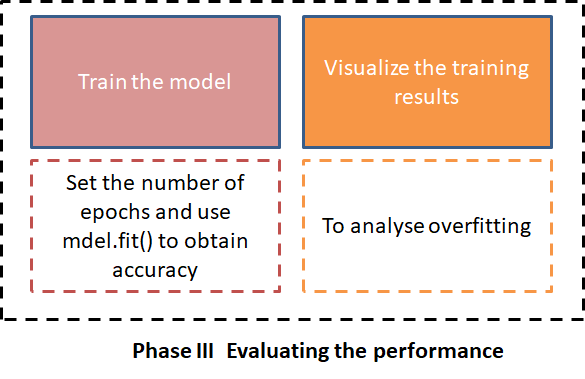

## Train the model

In [17]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 73s 773ms/step - loss: 1.3318 - accuracy: 0.4475 - val_loss: 1.0859 - val_accuracy: 0.5409
Epoch 2/10
92/92 [==============================] - 70s 758ms/step - loss: 0.9746 - accuracy: 0.6243 - val_loss: 0.9911 - val_accuracy: 0.5995
Epoch 3/10
92/92 [==============================] - 84s 913ms/step - loss: 0.7721 - accuracy: 0.7033 - val_loss: 0.8862 - val_accuracy: 0.6540
Epoch 4/10
92/92 [==============================] - 94s 1s/step - loss: 0.5953 - accuracy: 0.7827 - val_loss: 0.8942 - val_accuracy: 0.6676
Epoch 5/10
92/92 [==============================] - 90s 967ms/step - loss: 0.3801 - accuracy: 0.8685 - val_loss: 1.0536 - val_accuracy: 0.6649
Epoch 6/10
92/92 [==============================] - 98s 1s/step - loss: 0.2264 - accuracy: 0.9264 - val_loss: 1.1876 - val_accuracy: 0.6567
Epoch 7/10
92/92 [==============================] - 72s 784ms/step - loss: 0.1265 - accuracy: 0.9659 - val_loss: 1.3406 - val_accuracy: 0.6512
Epoch

## Visualize training results

Create plots of loss and accuracy on the training and validation sets:

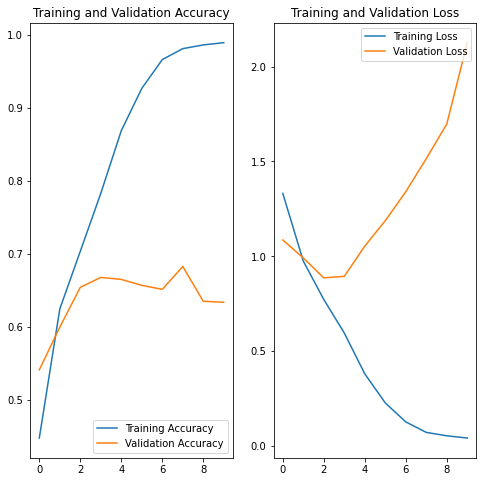

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observation: The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 60% accuracy on the validation set.
#### Action: Try to increase the overall performance of the model.

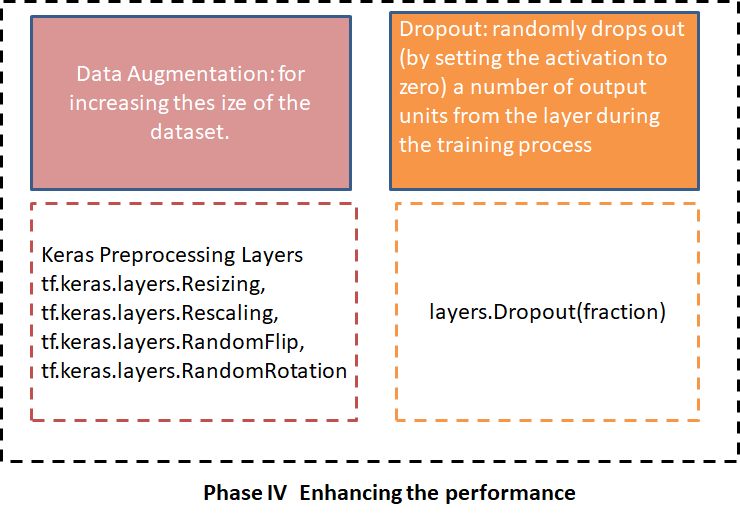

## Overfitting

1. In the plots above, the training accuracy is increasing linearly over time, 
2. whereas validation accuracy stalls around 60% in the training process. 
3. The difference in accuracy between training and validation accuracy is noticeable—a sign of [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

**When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.**

* Two techniqus to be used here are `data augmentation` and `Dropout`.

## Data augmentation

It is a technique to increase the diversity of the training set by applying random (but realistic) transformations, such as image rotation. Data Augmentation can be done as follows:

1. **Using Keras preprocessing layers, such as **
* `tf.keras.layers.Resizing`, 
* `tf.keras.layers.Rescaling`, 
* `tf.keras.layers.RandomFlip`, and 
* `tf.keras.layers.RandomRotation`.
2. **Using `tf.image` methods, such as **
* `tf.image.flip_left_right`, 
* `tf.image.rgb_to_grayscale`, 
* `tf.image.adjust_brightness`, 
* `tf.image.central_crop`, and 
* `tf.image.stateless_random*`.

Overfitting generally occurs when there are a small number of training examples. 
**Data augmentation - a technique to `increase the diversity of the training set` by applying random (but realistic) transformations, such as image rotation. 
It generates additional training data from the existing examples by augmenting them using random transformations. This helps expose the model to more aspects of the data and generalize better.**

In Keras data augmentation can be done through the preprocessing layers: 
`tf.keras.layers.RandomFlip`, 
`tf.keras.layers.RandomRotation`, and 
`tf.keras.layers.RandomZoom`. 
These can be included inside the model like other layers.

In [19]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

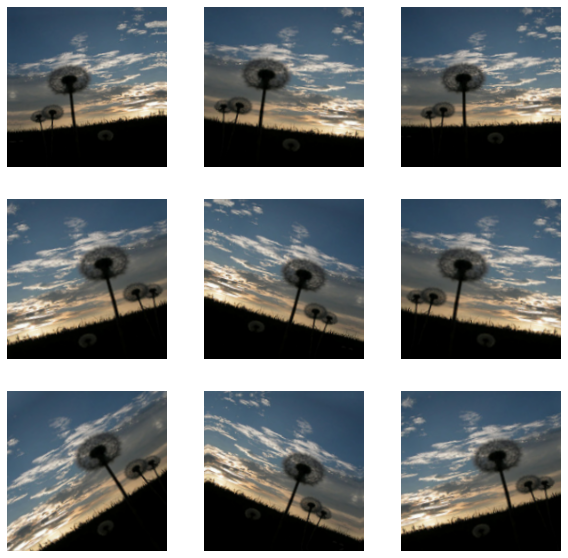

In [20]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Dropout - Another technique to reduce overfitting
When dropout is applied to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. 
Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. 
This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

## Create a new neural network with `tf.keras.layers.Dropout` before training it using the augmented images:

In [21]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile and train the model

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 86s 843ms/step - loss: 1.2834 - accuracy: 0.4527 - val_loss: 1.1683 - val_accuracy: 0.5477
Epoch 2/15
92/92 [==============================] - 90s 979ms/step - loss: 1.0127 - accuracy: 0.5974 - val_loss: 1.0438 - val_accuracy: 0.6049
Epoch 3/15
65/92 [====================>.........] - ETA: 33s - loss: 0.9116 - accuracy: 0.6477

## Visualize training results

After applying data augmentation and `tf.keras.layers.Dropout`, there is less overfitting than before, and training and validation accuracy are closer aligned:

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

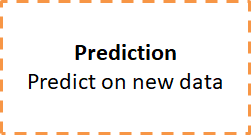

## Predict on new data

#### Use the model to classify an image that was not a part of the training or validation sets.

In [ ]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

Testing with random pictures

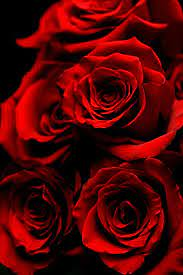

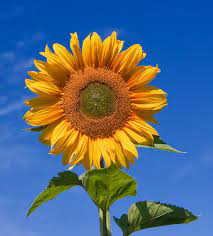

In [ ]:
from PIL import Image
img = Image.open("roses.jpg") 

img = tf.keras.utils.load_img("roses.jpg", target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [ ]:
from PIL import Image
img = Image.open("yellowrose.jpg") 

img = tf.keras.utils.load_img(
    "yellowrose", target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

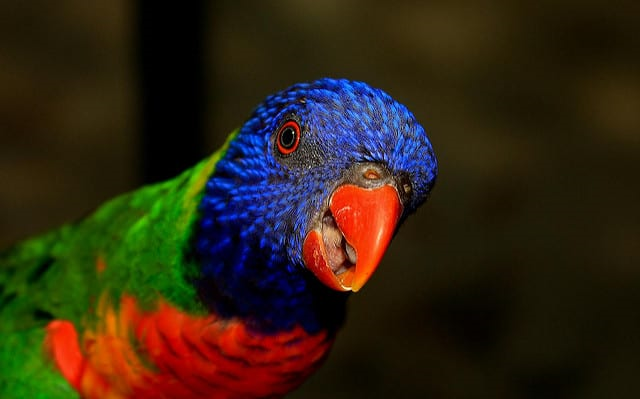

1) All the original images are just transformed (i.e. rotation, zooming, etc.) every epoch and then used for training, and 
2) Therefore the number of images in each epoch is equal to the number of original images you have.

In each epoch, the ImageDataGenerator applies a transformation on the images you have and use the transformed images for training. The set of transformations includes rotation, zooming, etc. 
By doing this you're somehow creating new data (i.e. also called data augmentation), but obviously the generated images are not totally different from the original ones. 
This way the learned model may be more robust and accurate as it is trained on different variations of the same image.

Basically we are augmenting the images when we use ImageDataGenerator and enabling its augmentation capabilities. 
But the word "augmentation" here does not mean, say, if we have 100 original training images we end up having 1000 images per epoch after augmentation (i.e. the number of training images does not increase per epoch). 
Instead, it means we use a different transformation of each image in each epoch; hence, if we train our model for, say, 5 epochs, we have used 5 different versions of each original image in training (or 100 * 5 = 500 different images in the whole training, instead of using just the 100 original images in the whole training). To put it differently, the total number of unique images increases in the whole training from start to finish, and not per epoch.
#### The augmented images are not stored in the memory, they are generated on the fly while training and lost after training. You can't read again those augmented images. 